## Setup

Import packages

In [1]:
from tracklist import TrackList
from data import load_analysis
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pylab as pylab


In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Define variable

In [3]:
pitch_classes = {
    0: 'C (also B♯, D#)',
    1: 'C♯, D♭ (also B#)',
    2: 'D (also C#, E#)',
    3: 'D♯, E♭ (also F#)',
    4: 'E (also D#, F♭)',
    5: 'F (also E♯, G#)',
    6: 'F♯, G♭ (also E#)',
    7: 'G (also F#, A#)',
    8: 'G♯, A♭',
    9: 'A (also G#, B#)',
    10: 'A♯, B♭ (also C#)',
    11: 'B (also A#, C♭)'
}
data_dir = '../dataset'
song = 0
trim_length = 20

Load data

In [4]:
meta = TrackList.load_from_dir(data_dir)
all_tracks = meta.get_track_ids()

## Investigate a single song

In [5]:
track_id = meta.get_track_ids()[song]
analysis = load_analysis(data_dir, track_id)
duration = analysis['duration']
key = pitch_classes[analysis['key']]
print(f"Track {track_id} lasts {duration} seconds and is in the {key} key")
analysis['segments'] = [seg for seg in analysis["segments"] if seg["start"] < trim_length]
segments = analysis['segments']
print(f"And has {len(segments)} segments in the first {trim_length} seconds")

Track 6QHYEZlm9wyfXfEM1vSu1P lasts 277.10666 seconds and is in the G♯, A♭ key
And has 72 segments in the first 20 seconds


In [6]:
track_df = pd.DataFrame(segments)
# Map value of pitches to keys and get max pitch
track_df["pitches"] = [dict(zip(pitch_classes.values(), track_df.pitches[i])) for i in range(len(track_df))]
track_df["chroma"] = [max(track_df.pitches[i], key=track_df.pitches[i].get) for i in range(len(track_df))]
track_df["max_pitch"] = [max(track_df.pitches[0].values()) for i in range(len(track_df))]

In [7]:
track_df.head()

,start,duration,confidence,pitches,chroma,max_pitch
0,0.00000,0.06998,0.000,"{'C (also B♯, D#)': 1.0, 'C♯, D♭ (also B#)': 0...","C (also B♯, D#)",1.0
1,0.06998,0.16118,0.325,"{'C (also B♯, D#)': 0.949, 'C♯, D♭ (also B#)':...","A♯, B♭ (also C#)",1.0
2,0.23116,0.24621,0.577,"{'C (also B♯, D#)': 1.0, 'C♯, D♭ (also B#)': 0...","C (also B♯, D#)",1.0
3,0.47737,0.27166,0.906,"{'C (also B♯, D#)': 0.224, 'C♯, D♭ (also B#)':...","G♯, A♭",1.0
4,0.74902,0.52299,1.000,"{'C (also B♯, D#)': 1.0, 'C♯, D♭ (also B#)': 0...","C (also B♯, D#)",1.0


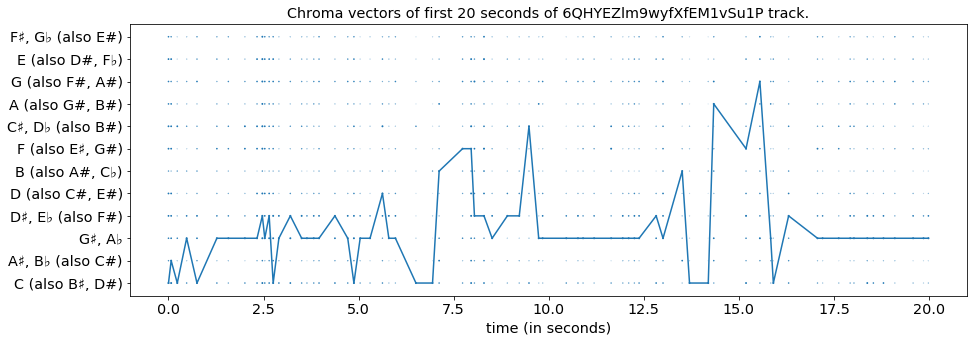

In [8]:
df = pd.concat([pd.DataFrame(segment, pitch_classes.values()).reset_index() for segment in segments])
df.columns = ['chroma', 'start', 'duration', 'confidence', 'max_pitch']

plt.plot(track_df.start, track_df.chroma)
plt.scatter(df.start, df.chroma, s=df.max_pitch, cmap=df.chroma)
plt.xlabel('time (in seconds)')
plt.title(f'Chroma vectors of first {trim_length} seconds of {track_id} track.')
plt.show()

## Investigate overall dataset

In [11]:
analyses = [load_analysis(data_dir, track) for track in all_tracks]
df = pd.DataFrame([analyses[i]["key"] for i in range(len(all_tracks))], columns=["pitch"])
df['key_confidences'] = [analyses[i]["key_confidence"] for i in range(len(all_tracks))]
df['modes'] = [analyses[i]["mode"] for i in range(len(all_tracks))]
df['mode_confidences'] = [analyses[i]["mode_confidence"] for i in range(len(all_tracks))]
df['durations'] = [analyses[i]["duration"] for i in range(len(all_tracks))]
df['no_segments'] = [len(analyses[i]["segments"]) for i in range(len(all_tracks))]
df['segment_lens'] = [[np.mean([seg['duration'] for seg in analyses[i]["segments"]])][0] for i in range(len(all_tracks))]
df['entropies'] = [np.mean(entropy([seg['pitches'] for seg in track['segments']], base=12)) for track in analyses]
df.describe()

,pitch,key_confidences,modes,mode_confidences,durations,no_segments,segment_lens,entropies
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,5.508964,0.472093,0.501992,0.490950,234.387876,888.515936,0.269700,2.575403
std,3.457608,0.253061,0.500245,0.183925,71.751231,301.531215,0.043916,0.124502
min,0.000000,0.000000,0.000000,0.000000,78.200000,271.000000,0.169184,2.075766
25%,2.000000,0.285750,0.000000,0.375000,193.937770,708.000000,0.237530,2.496891
50%,6.000000,0.486000,1.000000,0.504500,221.840000,826.500000,0.263967,2.565132
75%,9.000000,0.664000,1.000000,0.616000,261.084705,995.000000,0.296643,2.642356
max,11.000000,1.000000,1.000000,1.000000,1352.413300,4284.000000,0.479609,3.235441


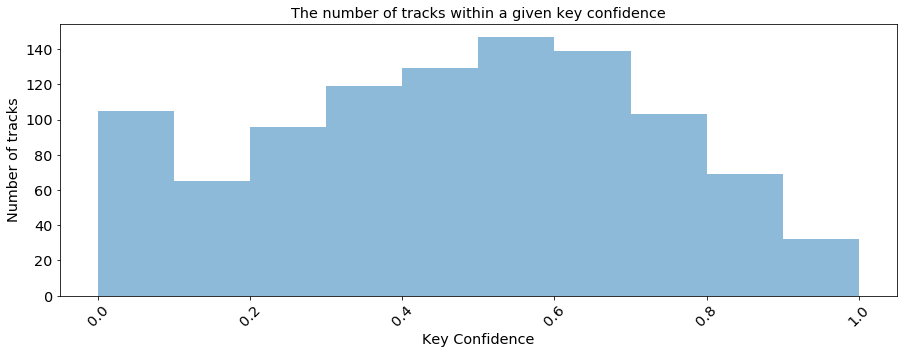

In [12]:
plt.hist(df.key_confidences, alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Key Confidence')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given key confidence')
plt.show()

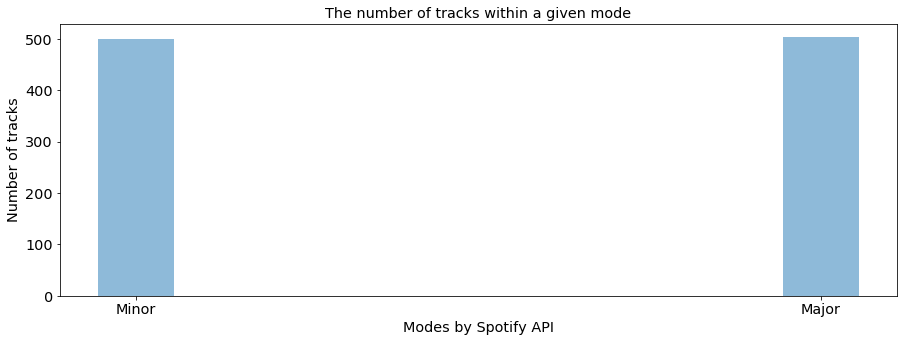

In [13]:
plt.hist(df.modes, alpha=0.5)
plt.xticks([0.05, 0.95], labels=("Minor", "Major"))
plt.xlabel('Modes by Spotify API')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given mode')
plt.show()


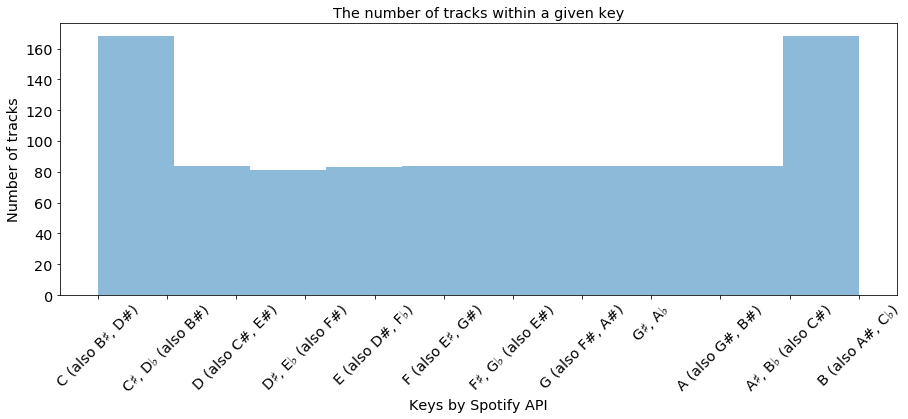

In [15]:
plt.hist(df.pitch, alpha=0.5)
plt.xticks(list(pitch_classes.keys()), labels=pitch_classes.values(), rotation=45)
plt.xlabel('Keys by Spotify API')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given key')
plt.show()


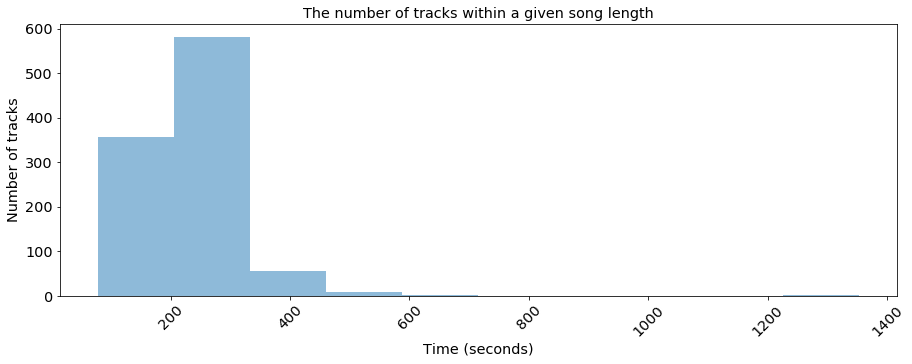

In [16]:
plt.hist(df.durations, alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given song length')
plt.show()

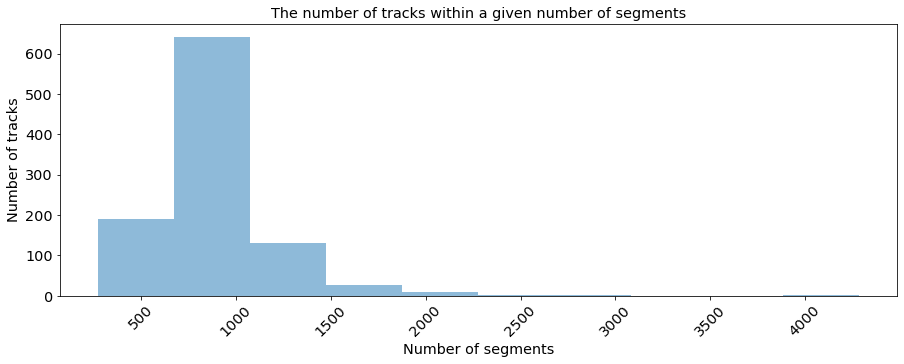

In [17]:
plt.hist(df.no_segments, alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Number of segments')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given number of segments')
plt.show()

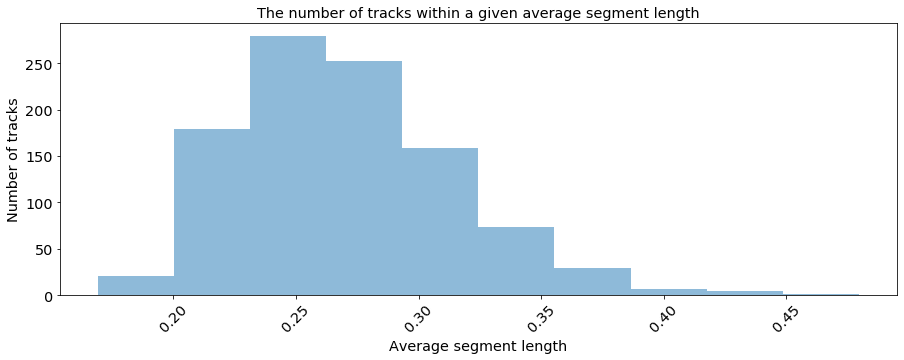

In [20]:
plt.hist(df.segment_lens, alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Average segment length')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given average segment length')
plt.show()

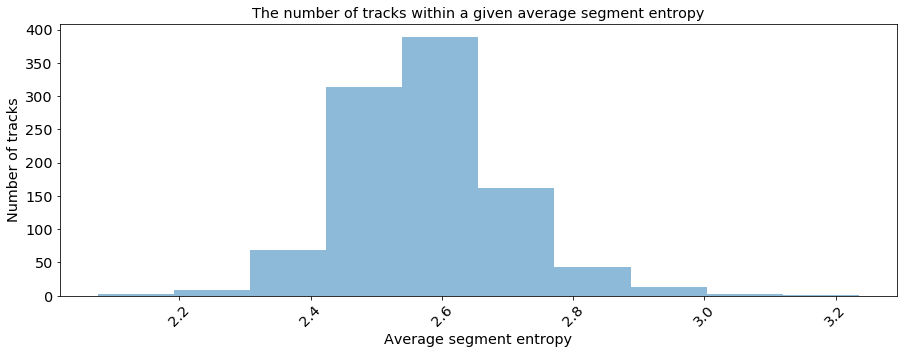

In [22]:
plt.hist(df.entropies, alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Average segment entropy')
plt.ylabel('Number of tracks')
plt.title(f'The number of tracks within a given average segment entropy')
plt.show()